In [1]:
library(Seurat)
library(data.table)
library(ggplot2)
library(flexclust)

Attaching SeuratObject

Loading required package: grid

Loading required package: lattice

Loading required package: modeltools

Loading required package: stats4



In [2]:
datasetName = 'prostate_prostate_HCLAdultProstate1'
#datasetName value: organ_tissue_authorYear without space
dataFormat = 'tsv'
#dataFormat value: tsv (tab separated), 10X (sparse)
setwd("/stor/public/hcad/db_v1/prostate_prostate_HCLAdultProstate1/")

In [3]:
# Load the organized dataset
if(dataFormat == 'tsv'){
    data.matrix <- read.table(paste0(datasetName,"_expression.tsv.gz"), h = T, row.names = 1)
} else{
   system(paste0("tar -zxvf ", datasetName, "_expression.tar.gz")) #Invoke the unix command
   data.matrix <- Read10X(data.dir = paste0(datasetName,"_expression"))
   # data.dir: Directory containing the matrix.mtx, genes.tsv (or features.tsv), and barcodes.tsv files provided by 10X.
}
# Load the metadata and annotation
data.metadata <- read.table(file = paste0(datasetName,"_metadata.tsv"), h = T, sep = "\t", row.names = 5)
data.annotation <- read.table(file = paste0(datasetName,"_annotation.tsv"), h = T, sep = "\t", row.names = 1)
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    data.annotation2 <- read.table(file = paste0(datasetName,"_annotation2.tsv"), h = T, sep = "\t", row.names = 1)
}

In [4]:
data.matrix <- data.matrix[, -1]
data.matrix[1:5, 1:5]
data.metadata[1:5, ]
data.annotation[1:5,]

,CTCGCAGCCTAGGTCCCG,CTCGCACATCCCAAGCGG,GCGGTCGTAAGTCGGT,GCGGACGTTGTAGTCG,CTCGCATATGTAAAGTAC
,<int>,<int>,<int>,<int>,<int>
A1BG,0,0,0,0,0
A1BG-AS1,0,0,0,0,0
A2M,0,0,0,0,0
A2M-AS1,0,0,0,0,0
A2ML1,0,0,0,0,0


,organ,region,subregion,sample_status,donor_ID,donor_gender,donor_age
,<chr>,<chr>,<lgl>,<chr>,<int>,<chr>,<chr>
CGAATAAACATGAT,prostate,prostate,NA,normal,6,Male,45Y
CGAGGACTCCAGAC,prostate,prostate,NA,normal,4,Male,45Y
CGATTCCAATACAG,prostate,prostate,NA,normal,2,Male,45Y
CGCCTTTCACACCC,prostate,prostate,NA,normal,2,Male,45Y
CGCGAGTAAACGCC,prostate,prostate,NA,normal,14,Male,45Y


[1] "Luminal cell"                     "Unknown epithelial cell_FOS high"
[3] "Intermediate epithelial cell"     "Intermediate epithelial cell"    
[5] "Epithelial cell_TPPP3 high"

In [5]:
# Pre-processing
min.cells = 3
# Modify the default value of these parameters according to original paper
dataobj <- CreateSeuratObject(counts = data.matrix, project = datasetName, min.cells = min.cells, meta.data = data.metadata)
dataobj <- AddMetaData(dataobj, metadata = data.annotation)
dataobj[["percent.mt"]] <- PercentageFeatureSet(dataobj, pattern = "^[Mm][Tt]")
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    dataobj <- AddMetaData(dataobj, metadata = data.annotation2)
}

Warning message in CreateSeuratObject.default(counts = data.matrix, project = datasetName, :
“Some cells in meta.data not present in provided counts matrix”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


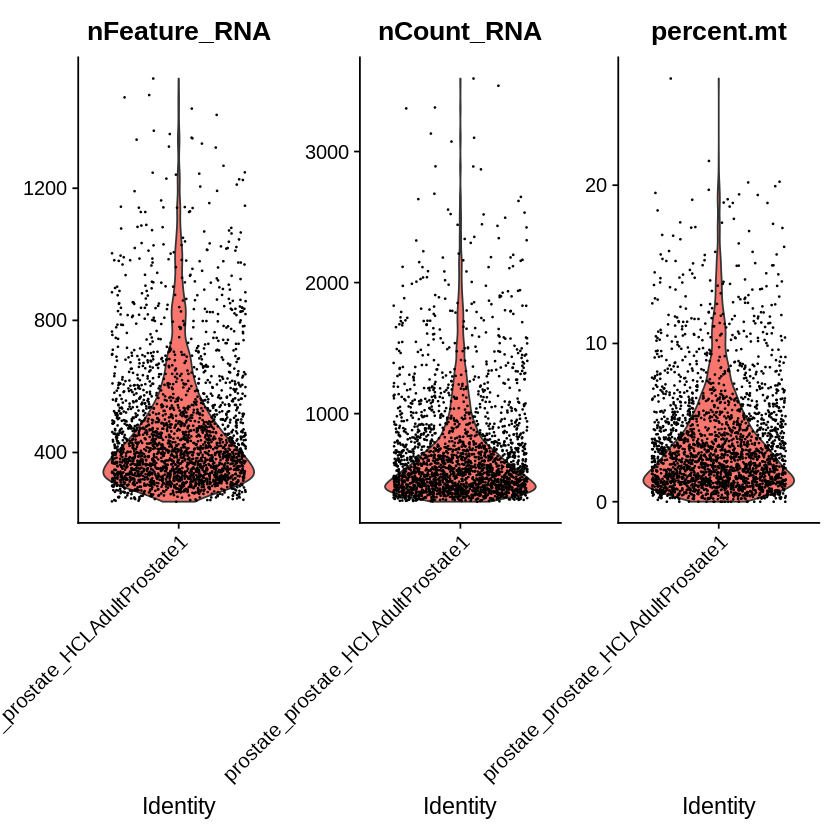

In [6]:
VlnPlot(dataobj, features = c('nFeature_RNA', 'nCount_RNA', 'percent.mt'), ncol = 3)

In [7]:
# QC
nFeature_RNA_range = c(200, 1000)
percent.mt.thre = 10
dataobj <- subset(dataobj, subset = nFeature_RNA > nFeature_RNA_range[1] & nFeature_RNA < nFeature_RNA_range[2] & percent.mt < percent.mt.thre)

In [8]:
# Normalization
# Two approaches
# 1. run standard log normalization 
dataobj <- NormalizeData(dataobj, normalization.method = "LogNormalize", scale.factor = 10000)
dataobj <- FindVariableFeatures(dataobj, selection.method = 'vst', nfeatures = 2000) # default feature number, nfeatures = 2000
dataobj <- ScaleData(dataobj, features = VariableFeatures(dataobj))
# 2. run sctransform 
# dataobj <- SCTransform(dataobj, vars.to.regress = "percent.mt", do.correct.umi = TRUE, do.scale = TRUE, do.center = TRUE)

Centering and scaling data matrix



In [9]:
# Dimensional Reduction
dataobj <- RunPCA(dataobj, features = VariableFeatures(object = dataobj))
# Determine the ‘dimensionality’ of the dataset according to elbow plot

PC_ 1 
Positive:  HLA-DRA, SRGN, CD74, TYROBP, C1QB, HLA-DPB1, RGS1, HLA-DPA1, C1QA, FCER1G 
	   HLA-DRB1, LAPTM5, BCL2A1, CXCL8, AIF1, CCL3, MS4A7, GPR183, HLA-DQA1, TMSB4X 
	   HLA-DQB1, HLA-DMA, C5AR1, IL1B, APOC1, CCL4, SDS, FGL2, FABP5, PLEK 
Negative:  KLK3, AZGP1, DHRS7, MSMB, RDH11, ANXA1, KLK2, NPY, ACPP, CLDN4 
	   SEC11C, MT2A, TACSTD2, CD9, DBI, TMEM59, EFNA1, H3F3B, MT1X, TSC22D1 
	   CALM2, MT1E, UQCRQ, GDF15, ADIRF, FXYD3, SFN, TFF1, XBP1, S100A10 
PC_ 2 
Positive:  IFI27, SPARCL1, AQP1, SELE, CCL2, PCAT19, GJA1, THBD, RNASE1, SOCS3 
	   IGFBP7, CSF3, SLC2A3, LRRC32, CD93, ADAMTS1, APOLD1, PLVAP, CAV1, ADAMTS4 
	   ID3, PLPP3, ACKR1, ESAM, GADD45B, EGR1, SPARC, IFI16, ADGRL4, JUNB 
Negative:  KLK3, MSMB, AZGP1, DHRS7, NPY, TYROBP, C1QB, ANXA1, C1QA, AIF1 
	   GPR183, ACPP, MS4A7, FCER1G, BCL2A1, C15orf48, RGS1, RDH11, CCL3, FABP5 
	   FTH1, FGL2, DBI, PLEK, LAPTM5, C5AR1, SEC11C, KLK2, MS4A6A, APOC1 
PC_ 3 
Positive:  KRT17, S100A2, S100A6, ACTG1, KRT19, ANXA2, MIR205HG,

Warning message in ElbowPlot(dataobj, ndims = 100):
“The object only has information for 50 reductions”


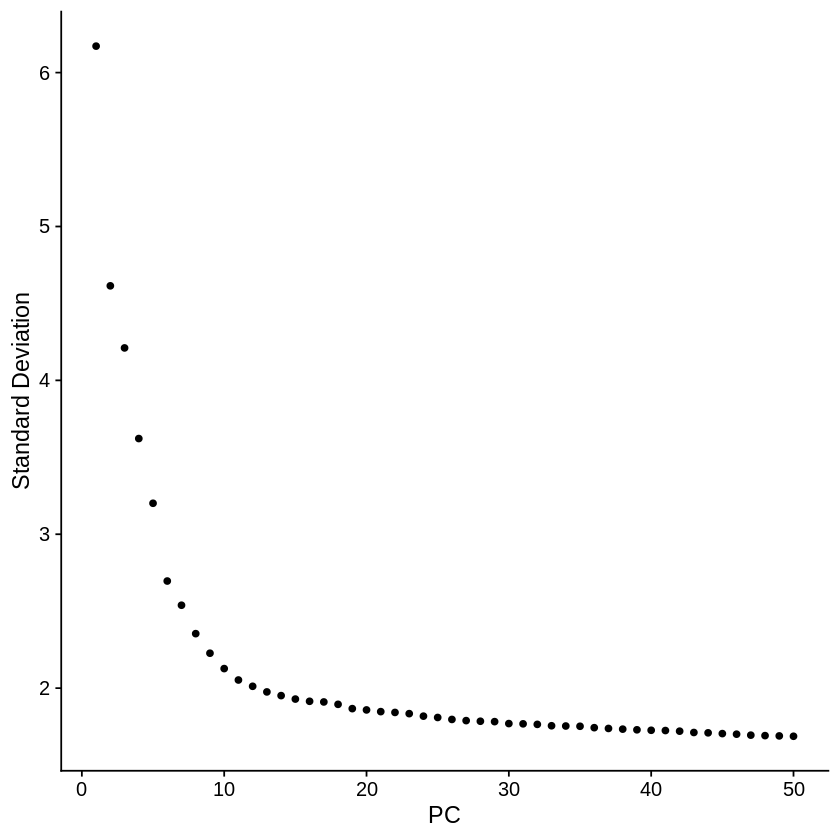

In [10]:
ElbowPlot(dataobj, ndims=100) 
# pdf(paste0(datasetName,"seurat.elbowplot.pdf"))

In [11]:
dev.off()
pcDim = 10 # set as 14 in this case 
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)
DimPlot(dataobj, reduction = "umap", label = TRUE)
# ggsave(paste0(datasetName,".seurat.umap.tiff", plot = p_umap, width = 8, height = 5)

null device 
          1

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
16:27:47 UMAP embedding parameters a = 0.9922 b = 1.112

16:27:47 Read 2193 rows and found 10 numeric columns

16:27:47 Using Annoy for neighbor search, n_neighbors = 30

16:27:47 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:27:47 Writing NN index file to temp file /tmp/RtmpDVZrXU/file38882e083397

16:27:47 Searching Annoy index using 1 thread, search_k = 3000

16:27:48 Annoy recall = 100%

16:27:48 Commencing smooth kNN distance calibration using 1 thread

16:27:48 Initializing fro

In [12]:
# Cluster the cells
dataobj <- FindNeighbors(dataobj, reduction = "pca", dims = 1:pcDim, nn.eps = 0.5)
dataobj <- FindClusters(dataobj, resolution = 0.9)
# umap
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2193
Number of edges: 74024

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7964
Number of communities: 11
Elapsed time: 0 seconds


16:27:55 UMAP embedding parameters a = 0.9922 b = 1.112

16:27:55 Read 2193 rows and found 10 numeric columns

16:27:55 Using Annoy for neighbor search, n_neighbors = 30

16:27:55 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:27:55 Writing NN index file to temp file /tmp/RtmpDVZrXU/file38884f1e847b

16:27:55 Searching Annoy index using 1 thread, search_k = 3000

16:27:56 Annoy recall = 100%

16:27:56 Commencing smooth kNN distance calibration using 1 thread

16:27:56 Initializing from normalized Laplacian + noise

16:27:56 Commencing optimization for 500 epochs, with 88714 positive edges

16:28:02 Optimization finished



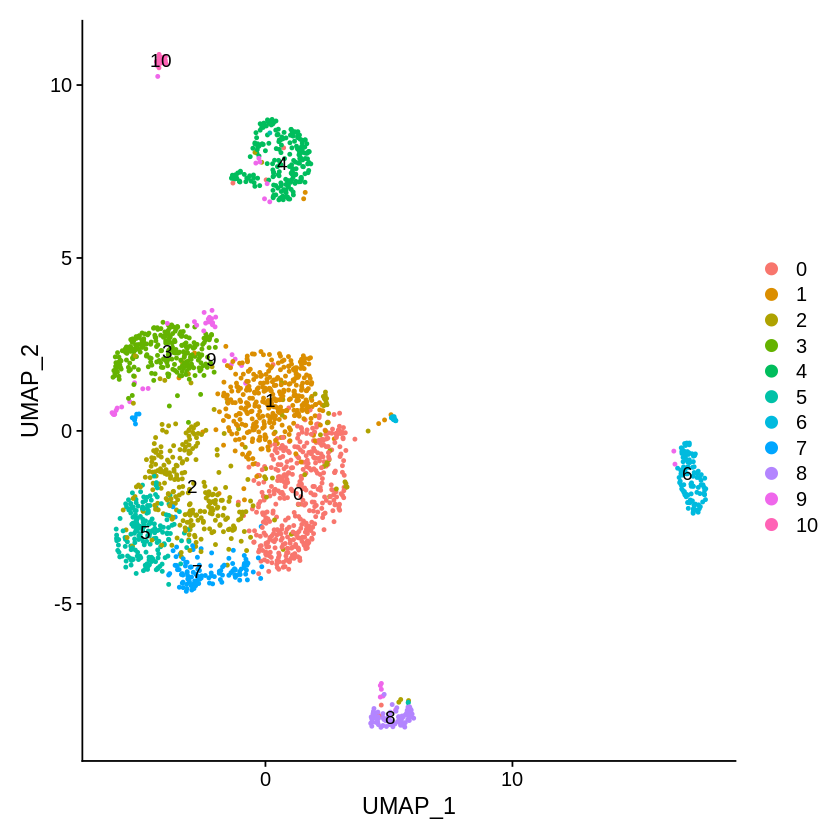

In [13]:
p_umap <- DimPlot(dataobj, reduction = "umap", label = TRUE)
p_umap

In [14]:
#ggsave(paste0(datasetName,".seurat.umap.tiff"), plot = p_umap, width = 8, height = 5)

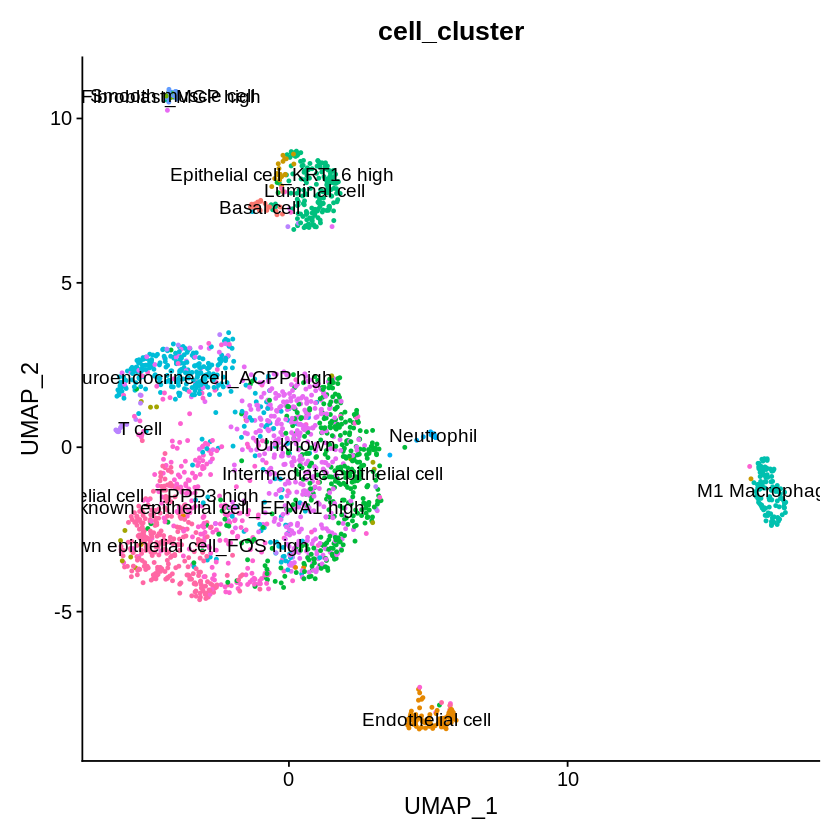

In [15]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE, group.by = "cell_cluster") + NoLegend()
p_umap2

In [16]:
#ggsave(paste0(datasetName,".seurat.umap_orig.tiff"), plot = p_umap2, width = 8, height = 5)

In [17]:
# Finding cluster markers 
dataobj.markers <- FindAllMarkers(dataobj, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
write.table(dataobj.markers, file = paste0(datasetName,".__seurat.markers.v1.1.txt"), sep = "\t", quote = F, row.names = F, col.names = T)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10



In [18]:
new.cluster.ids <- c("Prostate-Epithelial tissue-Epithelial cell-EFNA1",
                     "Prostate-Nerve tissue-Neuroendocrine cell-ACPP",
                     "Prostate-Connective tissue-T cell- MT-ATP6 MT-ND4",
                     "Prostate-Epithelial tissue-Epithelial cell-FOS",
                     "Prostate-Connective tissue-NK T cell-MT2A GTF3C6",
                     "Prostate-Epithelial tissue-Epithelial cell-ID1",
                     "Prostate-Epithelial tissue-Luminal cell-KRT17",
                     "Prostate-Connective tissue-Macrophage-TYROBP",
                     "Prostate-Epithelial tissue-Endothelial cell-IFI27",
                     "Prostate-Muscle tissue-Smooth muscle cell-ACTA2",
                     "Prostate-Connective tissue-NK T cell-RPS27 RGS1"
                    )
names(new.cluster.ids) <- levels(dataobj)
dataobj <- RenameIdents(dataobj, new.cluster.ids)

In [19]:
#ggsave(paste0(datasetName,".seurat.umap_hcad.tiff"), plot = p_umap2, width = 8, height = 5)

In [20]:
#saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))

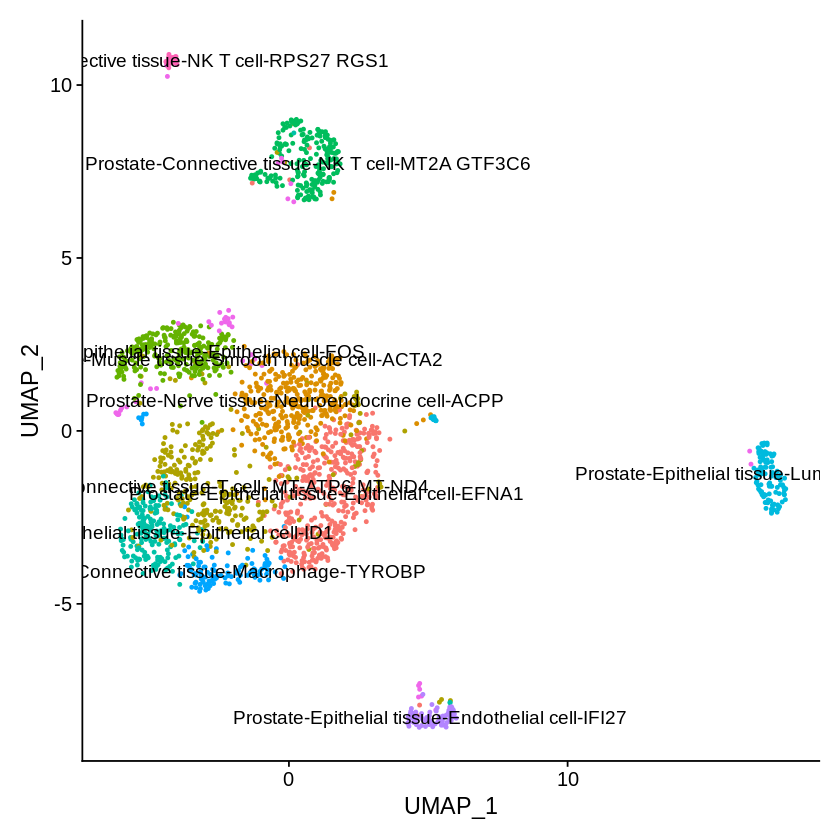

In [22]:
pp_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE)+ NoLegend()
pp_umap2

In [79]:
saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))